In [1]:
import warnings
warnings.filterwarnings("ignore")

# Choropleth Mapping



## Principles


Choropleth maps play a prominent role in geographic data science as they allow
us to display non-geographic attributes or variables on a geographic map. The
word choropleth stems from the root "choro", meaning "region". As such
choropleth maps represent data at the region level, and are appropriate for
areal unit data where each observation combines a value of an attribute and a
geometric figure, usually a polygon. Choropleth maps derive from an earlier era
where cartographers faced technological constraints that precluded the use of
unclassed maps where each unique attribute value could be represented by a
distinct symbol or color. Instead, attribute values were grouped into a smaller
number of classes, usually not more than 12. Each class was associated with a
unique symbol that was in turn applied to all observations with attribute values
falling in the class.

Although today these technological constraints are no longer binding, and
unclassed mapping is feasible, there are still good reasons for adopting a
classed approach. Chief among these is to reduce the cognitive load involved in
parsing the complexity of an unclassed map. A choropleth map reduces this
complexity by drawing upon statistical and visualization theory to provide an
effective representation of the spatial distribution of the attribute values
across the areal units. 

The effectiveness of a choropleth map will be a
function of the choice of classification scheme together with the color or
symbolization strategy adopted. In broad terms, the classification scheme
defines the number of classes as well as the rules for assignment, while the
symbolization should convey information about the value differentiation across
the classes.

In this chapter we first discuss the approaches used to classify attribute
values. This is followed by an overview of color theory and the implications of
different color schemes for effective map design. We combine theory and practice
by exploring how these concepts are implemented in different Python packages,
including `geopandas`, and `PySAL`.




In [2]:
%matplotlib inline

import seaborn
import pandas
import geopandas
import pysal
import numpy
import mapclassify
import matplotlib.pyplot as plt

## Quantitative data classification 

Data classification considers the problem of 
partitioning the attribute values into mutually exclusive and exhaustive
groups. The precise manner in which this is done will be a function of the
measurement scale of the attribute in question. For quantitative attributes
(ordinal, interval, ratio scales) the classes will have an explicit ordering.
More formally, the classification problem is to define class boundaries such
that

$$
c_j < y_i \le  c_{j+1} \ \forall y_i \in C_{j}
$$

where $y_i$ is the
value of the attribute for spatial location $i$, $j$ is a class index, and $c_j$
represents the lower bound of interval $j$.

Different classification schemes obtain from their definition of the class
boundaries. The choice of the classification scheme should take into
consideration the statistical distribution of the attribute values.

To illustrate these considerations, we will examine regional income data for the
32 Mexican states used in the paper by {cite}`Rey_2010`. The variable we focus on is per capita gross domestic product
for 1940 (PCGDP1940):

In [3]:
mx = geopandas.read_file("../data/mexico/mexicojoin.shp")
mx[['NAME', 'PCGDP1940']].head()

,NAME,PCGDP1940
0,Baja California Norte,22361.0
1,Baja California Sur,9573.0
2,Nayarit,4836.0
3,Jalisco,5309.0
4,Aguascalientes,10384.0


Which displays the following statistical distribution:

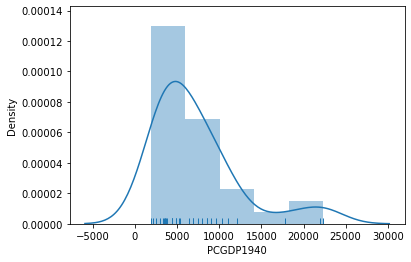

In [4]:
h = seaborn.distplot(mx['PCGDP1940'], bins=5, rug=True);

As we can see, the distribution is positively skewed as in common in regional income studies. In other words,
the mean exceeds the median (`50%`, in the table below), leading the to fat right tail in the figure. As
we shall see, this skewness will have implications for the choice of choropleth
classification scheme.

In [5]:
mx['PCGDP1940'].describe()

count       32.000000
mean      7230.531250
std       5204.952883
min       1892.000000
25%       3701.750000
50%       5256.000000
75%       8701.750000
max      22361.000000
Name: PCGDP1940, dtype: float64

For quantitative attributes we first sort the data by their value,
such that $x_0 \le x_2 \ldots \le x_{n-1}$. For a prespecified number of classes
$k$, the classification problem boils down to selection of $k-1$ break points
along the sorted values that separate the values into mutually exclusive and
exhaustive groups.

In fact, the determination of the histogram above can
be viewed as one approach to this selection.
The method `seaborn.distplot` uses the matplotlib `hist`
function under the hood to determine the class boundaries and the counts of
observations in each class. In the figure, we have five classes which can be
extracted with an explicit call to the `hist` function:

In [6]:
counts, bins, patches = h.hist(mx['PCGDP1940'], bins=5)

The `counts` object captures how many observations each category in the classification has:

In [7]:
counts

array([17.,  9.,  3.,  1.,  2.])

The `bin` object stores these break points we are interested in when considering classification schemes (the `patches` object can be ignored in this context, as it stores the geometries of the histogram plot):

In [8]:
bins

array([ 1892. ,  5985.8, 10079.6, 14173.4, 18267.2, 22361. ])

This yields 5 bins, with the first having a lower bound of 1892 and an upper
bound of 5985.8 which contains 17 observations. 
The determination of the
interval width ($w$) and the number of bins in `seaborn` is based on the Freedman-Diaconis rule:

$$
w = 2 * IQR * n^{-1/3}
$$

where $IQR$ is the inter quartile
range of the attribute values. Given $w$ the number of bins ($k$) is:

$$k=(max-
min)/w.$$

Below we present several approaches to create these break points that follow criteria that can be of interest in different contexts, as they focus on different priorities.
 
### Equal Intervals

The Freedman-Diaconis approach provides a rule to determine the width and, in
turn, the number of bins for the classification. This is a special case of a
more general classifier known as "equal intervals", where each of the bins has
the same width in the value space. For a given value of $k$, equal intervals
classification splits the range of the attribute space into $k$ equal length
intervals, with each interval having a width $w = \frac{x_0 - x_{n-1}}{k}$. Thus
the maximum class is $(x_{n-1}-w, x_{n-1}]$ and the first class is $(-\infty,
x_{n-1} - (k-1)w]$.

Equal intervals have the dual advantages of simplicity and ease of
interpretation. However, this rule only considers the extreme values of the
distribution and, in some cases, this can result in one or more classes being
sparse. This is clearly the case in our income dataset, as the majority of the
values are placed into the first two classes leaving the last three classes
rather sparse:

In [9]:
ei5 = mapclassify.EqualInterval(mx['PCGDP1940'], k=5)
ei5

EqualInterval               

      Interval         Count
----------------------------
[ 1892.00,  5985.80] |    17
( 5985.80, 10079.60] |     9
(10079.60, 14173.40] |     3
(14173.40, 18267.20] |     1
(18267.20, 22361.00] |     2

 Note that each of the intervals, however, has equal width of
$w=4093.8$. This value of $k=5$ also coincides with the default classification
in the `seaborn` histogram displayed in Figure 1. It should also be noted that the first class is closed on the lower bound,
in contrast to the general approach defined in Equation (1).

### Quantiles
To avoid the potential problem of sparse classes, the quantiles of
the distribution can be used to identify the class boundaries. Indeed, each
class will have approximately $\mid\frac{n}{k}\mid$ observations using the quantile
classifier. If $k=5$ the sample quintiles are used to define the upper limits of
each class resulting in the following classification:

In [10]:
q5 = mapclassify.Quantiles(mx.PCGDP1940, k=5)
q5

Quantiles                   

      Interval         Count
----------------------------
[ 1892.00,  3576.20] |     7
( 3576.20,  4582.80] |     6
( 4582.80,  6925.20] |     6
( 6925.20,  9473.00] |     6
( 9473.00, 22361.00] |     7

Note that while the numbers of values in each class are roughly equal, the
widths of the first four intervals are rather different:

In [11]:
q5.bins[1:]-q5.bins[:-1]

array([ 1006.6,  2342.4,  2547.8, 12888. ])

While quantiles does avoid the pitfall of sparse classes, this classification is
not problem free. The varying widths of the intervals can be markedly different
which can lead to problems of interpretation. A second challenge facing quantiles
arises when there are a large number of duplicate values in the distribution
such that the limits for one or more classes become ambiguous. For example, if one had a variable with $n=20$ but 10 of the observations took on the same value which was the minimum observed, then for values of $k>2$, the class boundaries become ill-defined since a simple rule of splitting at the $n/k$ ranked observed value would depend upon how ties are treated when ranking.

In [12]:
numpy.random.seed(12345)
x = numpy.random.randint(0,10,20)
x[0:10] = x.min()
x

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 7, 6, 0, 2, 9, 1, 2, 6, 7])

In [13]:
ties = mapclassify.Quantiles(x, k=5)
ties

Quantiles           

  Interval     Count
--------------------
[0.00, 0.00] |    11
(0.00, 1.40] |     1
(1.40, 6.20] |     4
(6.20, 9.00] |     4

In [14]:
x

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 7, 6, 0, 2, 9, 1, 2, 6, 7])

In [15]:
ux = numpy.unique(x)

In [16]:
ux

array([0, 1, 2, 6, 7, 9])

In this case, `mapclassify` will issue a warning alerting the user to the issue that this sample does not contain enough unique values to form 
the number of well-defined classes requested.  It then forms a lower number of classes using pseudo quantiles, or quantiles defined on the unique values in the sample, and then uses the pseudo quantiles to classify all the values.

In [17]:
np = numpy
import scipy.stats as stats

In [18]:
k = 5
w = 100.0 / k
p = np.arange(w, 100+w, w)
p

array([ 20.,  40.,  60.,  80., 100.])

In [19]:
q = np.array([stats.scoreatpercentile(x, pct) for pct in p])
q

array([0. , 0. , 1.4, 6.2, 9. ])

In [20]:
np.array([stats.scoreatpercentile(x, pct) for pct in np.arange(20, 120, 20)])

array([0. , 0. , 1.4, 6.2, 9. ])

In [21]:
p

array([ 20.,  40.,  60.,  80., 100.])

### Mean-standard deviation

Our third classifier uses the sample mean $\bar{x} =
\frac{1}{n} \sum_{i=1}^n x_i$ and sample standard deviation $s = \sqrt{
\frac{1}{n-1} \sum_{i=1}^n (x_i - \bar{x})  }$ to define class boundaries as
some distance from the sample mean, with the distance being a multiple of the
standard deviation. For example, a common definition for $k=5$ is to set the
upper limit of the first class to two standard deviations ($c_{0}^u = \bar{x} - 2 s$), and the intermediate
classes to have upper limits within one standard deviation ($c_{1}^u = \bar{x}-s,\ c_{2}^u = \bar{x}+s, \ c_{3}^u
= \bar{x}+2s$). Any values greater (smaller) than two standard deviations above (below) the mean
are placed into the top (bottom) class.

In [22]:
msd = mapclassify.StdMean(mx['PCGDP1940'])
msd

StdMean                     

      Interval         Count
----------------------------
(    -inf, -3179.37] |     0
(-3179.37,  2025.58] |     1
( 2025.58, 12435.48] |    28
(12435.48, 17640.44] |     0
(17640.44, 22361.00] |     3

This classifier is best used when data is normally distributed or, at least, when the sample mean is a meaningful measure to anchor the classification around. Clearly this is
not the case for our income data as the positive skew results in a loss of
information when we use the standard deviation. The lack of symmetry leads to
an inadmissible upper bound for the first  class as well as a concentration of the
vast majority of values in the middle class.

### Maximum Breaks

The maximum breaks classifier decides where to set the break points between
classes by considering the difference between sorted values. That is, rather
than considering a value of the dataset in itself, it looks at how apart each
value is from the next one in the sorted sequence. The classifier then places
the the $k-1$ break points in between the pairs of values most stretched apart from
each other in the entire sequence, proceeding in descending order relative to
the size of the breaks:

In [23]:
mb5 = mapclassify.MaximumBreaks(mx['PCGDP1940'], k=5)
mb5

MaximumBreaks               

      Interval         Count
----------------------------
[ 1892.00,  5854.00] |    17
( 5854.00, 11574.00] |    11
(11574.00, 14974.00] |     1
(14974.00, 19890.50] |     1
(19890.50, 22361.00] |     2

Maximum breaks is an appropriate approach when we are interested in making sure
observations in each class are separated from those in neighboring classes. As
such, it works well in cases where the distribution of values is not unimodal.
In addition, the algorithm is relatively fast to compute. However, its
simplicity can sometimes cause unexpected results. To the extent in only
considers the top $k-1$ differences between consecutive values, other more nuanced
within-group differences and dissimilarities can be ignored.

### Box-Plot

The box-plot classification is a blend of the quantile and
standard deviation classifiers. Here $k$ is predefined to six, with the upper limit of class 0 set
to $q_{0.25}-h \, IQR$. $IQR = q_{0.75}-q_{0.25}$ is the
inter-quartile range; $h$ corresponds to the hinge, or the multiplier of the $IQR$ to obtain the bounds of the whiskers. The lower limit of the sixth class is set to $q_{0.75}+h \,
IQR$. Intermediate classes have their upper limits set to the 0.25, 0.50 and
0.75 percentiles of the attribute values.

In [24]:
bp = mapclassify.BoxPlot(mx['PCGDP1940'])
bp

BoxPlot                     

      Interval         Count
----------------------------
(    -inf, -3798.25] |     0
(-3798.25,  3701.75] |     8
( 3701.75,  5256.00] |     8
( 5256.00,  8701.75] |     8
( 8701.75, 16201.75] |     5
(16201.75, 22361.00] |     3

Any values falling into either of the extreme classes are defined as outliers.
Note that because the income values are non-negative by definition, the lower
outlier class has an inadmissible upper bound meaning that lower outliers would
not be possible for this sample.

The default value for the hinge is $h=1.5$ in
PySAL. However, this can be specified by the user for an alternative classification:

In [25]:
bp1 = mapclassify.BoxPlot(mx['PCGDP1940'], hinge=1)
bp1

BoxPlot                     

      Interval         Count
----------------------------
(    -inf, -1298.25] |     0
(-1298.25,  3701.75] |     8
( 3701.75,  5256.00] |     8
( 5256.00,  8701.75] |     8
( 8701.75, 13701.75] |     5
(13701.75, 22361.00] |     3

Doing so will affect the definition of the outlier classes, as well as the
neighboring internal classes.

### Head-Tail Breaks

The head tail algorithm {cite}`Jiang_2013` is based on a recursive partitioning of the data using splits around
iterative means. The splitting process continues until the distributions within each of
the classes no longer display a heavy-tailed distribution in the sense that
there is a balance between the number of smaller and larger values assigned to
each class.

In [26]:
ht = mapclassify.HeadTailBreaks(mx['PCGDP1940'])
ht

HeadTailBreaks              

      Interval         Count
----------------------------
[ 1892.00,  7230.53] |    20
( 7230.53, 12244.42] |     9
(12244.42, 20714.00] |     1
(20714.00, 22163.00] |     1
(22163.00, 22361.00] |     1

For data with a heavy-tailed distribution, such as power law and log normal
distributions, the head tail breaks classifier  can be particularly
effective.

### Jenks Caspall

This approach, as well as the following two, tackles the classification
challenge from a heuristic perspective, rather than from deterministic one.
Originally proposed by {cite}`Jenks_1971`, this algorithm aims to minimize
the sum of absolute deviations around class means. The approach begins with a
prespecified number of classes and an arbitrary initial set of class breaks -
for example using quintiles. The algorithm attempts to improve the objective
function by considering the movement of observations between adjacent classes.
For example, the largest value in the lowest quintile would be considered for
movement into the second quintile, while the lowest value in the second
quintile would be considered for a possible move into the first quintile. The
candidate move resulting in the largest reduction in the objective function
would be made, and the process continues until no other improving moves are
possible.

In [27]:
numpy.random.seed(12345)
jc5 = mapclassify.JenksCaspall(mx['PCGDP1940'], k=5)
jc5

JenksCaspall                

      Interval         Count
----------------------------
[ 1892.00,  2934.00] |     4
( 2934.00,  4414.00] |     9
( 4414.00,  6399.00] |     5
( 6399.00, 12132.00] |    11
(12132.00, 22361.00] |     3

### Fisher Jenks

The second optimal algorithm adopts a dynamic programming approach to minimize
the sum of the absolute deviations around class medians. In contrast to the
Jenks-Caspall approach, Fisher-Jenks is guaranteed to produce an optimal
classification for a prespecified number of classes:

In [28]:
numpy.random.seed(12345)
fj5 = mapclassify.FisherJenks(mx['PCGDP1940'], k=5)
fj5

FisherJenks                 

      Interval         Count
----------------------------
[ 1892.00,  5309.00] |    17
( 5309.00,  9073.00] |     8
( 9073.00, 12132.00] |     4
(12132.00, 17816.00] |     1
(17816.00, 22361.00] |     2

### Max-p

Finally, the max-p classifiers adopts the algorithm underlying the max-p region
building method {cite}`Duque_2011` to the case of map classification. It is similar in spirit to
Jenks Caspall in that it considers greedy swapping between adjacent classes to
improve the objective function. It is a heuristic, however, so unlike
Fisher-Jenks, there is no optimal solution guaranteed:

In [29]:
mp5 = mapclassify.MaxP(mx['PCGDP1940'], k=5)
mp5

MaxP                        

      Interval         Count
----------------------------
[ 1892.00,  3569.00] |     7
( 3569.00,  5309.00] |    10
( 5309.00,  7990.00] |     5
( 7990.00, 10384.00] |     5
(10384.00, 22361.00] |     5

### Comparing Classification schemes

As a special case of clustering, the definition of
the number of classes and the class boundaries pose a problem to the map
designer. Recall that the Freedman-Diaconis rule was said to be optimal,
however, the optimality necessitates the specification of an objective function.
In the case of Freedman-Diaconis, the objective function is to minimize the
difference between the area under estimated kernel density based on the sample
and the area under the theoretical population distribution that generated the
sample.

This notion of statistical fit is an important one. However, it is not the
only consideration when evaluating classifiers for the purpose of choropleth
mapping. Also relevant is the spatial distribution of the attribute values and
the ability of the classifier to convey a sense of that spatial distribution. As
we shall see, this is not necessarily directly related to the statistical
distribution of the attribute values. We will return to a joint consideration of both
the statistical and spatial distribution of the attribute values in comparison
of classifiers below.

For map classification, one optimality criterion that
can be used is a measure of fit. In PySAL the "absolute deviation around class
medians" (ADCM) is calculated and provides a measure of fit that allows for
comparison of alternative classifiers for the same value of $k$.

To see this, we can compare different classifiers for $k=5$ on the Mexico data:

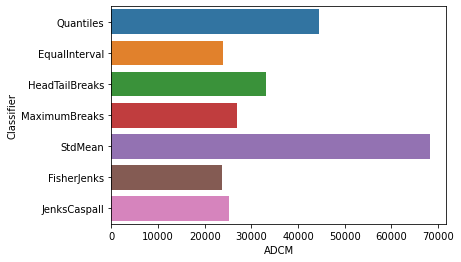

In [30]:
class5 = q5, ei5, ht, mb5, msd, fj5, jc5
fits = numpy.array([ c.adcm for c in class5])
data = pandas.DataFrame(fits)
data['classifier'] = [c.name for c in class5]
data.columns = ['ADCM', 'Classifier']
ax = seaborn.barplot(y='Classifier', x='ADCM', data=data)

As is to be expected, the Fisher-Jenks classifier dominates all other k=5
classifiers with an ADCM of 23,729. Interestingly, the equal interval classifier
performs well despite the problems associated with being sensitive to the
extreme values in the distribution. The mean-standard deviation classifier has a
very poor fit due to the skewed nature of the data and the concentrated
assignment of the majority of the observations to the central class.

The ADCM provides a global measure of fit which can be used to compare the
alternative classifiers. As a complement to this global perspective, it can be
revealing to consider how each of the spatial observations was classified across
the alternative approaches. To do this we can add the class bin attribute (`yb`)
generated by the PySAL classifiers as additional columns in the data frame and
present these jointly in a table:

In [31]:
mx['q540'] = q5.yb
mx['ei540'] = ei5.yb
mx['ht40'] = ht.yb
mx['mb540'] = mb5.yb
mx['msd40'] = msd.yb
mx['fj540'] = fj5.yb
mx['jc540'] = jc5.yb

In [32]:
mxs = mx.sort_values('PCGDP1940')

In [33]:
def highlight_values(val):
    if val==0:
        return 'background-color: %s' % '#ffffff'
    elif val==1:
        return 'background-color: %s' % '#e0ffff'
    elif val==2:
        return 'background-color: %s' % '#b3ffff'
    elif val==3:
        return 'background-color: %s' % '#87ffff'
    elif val==4:
        return 'background-color: %s' % '#62e4ff'
    else:
        return ''

In [34]:
t = mxs[['NAME', 'PCGDP1940', 'q540', 'ei540', 'ht40', 'mb540', 'msd40', 'fj540', 'jc540']]
t.style.applymap(highlight_values)

,NAME,PCGDP1940,q540,ei540,ht40,mb540,msd40,fj540,jc540
19,Oaxaca,1892.000000,0,0,0,0,1,0,0
18,Guerrero,2181.000000,0,0,0,0,2,0,0
20,Tabasco,2459.000000,0,0,0,0,2,0,0
21,Chiapas,2934.000000,0,0,0,0,2,0,0
8,Michoacan de Ocampo,3327.000000,0,0,0,0,2,0,1
9,Mexico,3408.000000,0,0,0,0,2,0,1
15,Puebla,3569.000000,0,0,0,0,2,0,1
17,Tlaxcala,3605.000000,1,0,0,0,2,0,1
27,Zacatecas,3734.000000,1,0,0,0,2,0,1
14,Campeche,3758.000000,1,0,0,0,2,0,1


Inspection of this table reveals a number of interesting results. First, the
only Mexican state that is treated consistently across the k=5 classifiers is
Baja California Norte which is placed in the highest class by all classifiers.
Second, the mean-standard deviation classifier has an empty first class due to
the inadmissible upper bound and the over-concentration of values in the central
class (2).

Finally, we can consider a meso-level view of the classification
results by comparing the number of values assigned to each class across the
different classifiers:

In [35]:
pandas.DataFrame({c.name: c.counts for c in class5},
                 index=['Class-{}'.format(i) for i in range(5)])

,Quantiles,EqualInterval,HeadTailBreaks,MaximumBreaks,StdMean,FisherJenks,JenksCaspall
Class-0,7,17,20,17,0,17,4
Class-1,6,9,9,11,1,8,9
Class-2,6,3,1,1,28,4,5
Class-3,6,1,1,1,0,1,11
Class-4,7,2,1,2,3,2,3


Doing so highlights the similarities between Fisher Jenks and equal intervals as
the distribution counts are very similar as the two approaches agree on all 17
states assigned to the first class. Indeed, the only observation that
distinguishes the two classifiers is the treatment of Baja California Sur which
is kept in class 1 in equal intervals, but assigned to class 2 by Fisher Jenks.

## Color

Having considered the evaluation of the statistical distribution of
the attribute values and the alternative classification approaches, the next
step is to select the symbolization and color scheme. Together with the choice of classifier, these will determine the overall
effectiveness of the choropleth map in representing the spatial
distribution of the attribute values.

Let us start by refreshing the `mx` object and exploring the base polygons for the Mexican states:

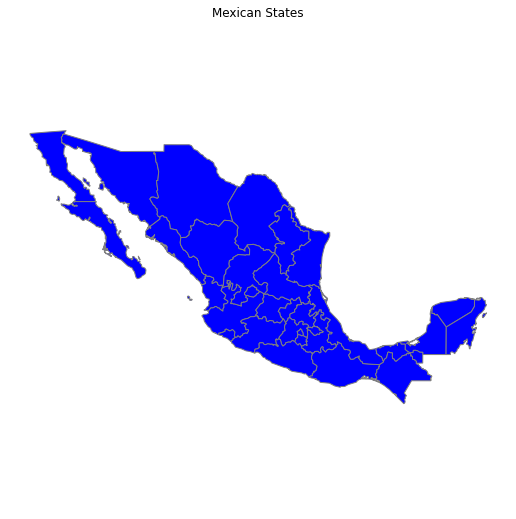

In [36]:
mx = geopandas.read_file('../data/mexico/mexicojoin.shp')
f, ax = plt.subplots(1, figsize=(9, 9))
mx.plot(ax=ax, color='blue', edgecolor='grey')
ax.set_axis_off()
ax.set_title('Mexican States')
plt.axis('equal')
plt.show()

Prior to examining the attribute values it is important to note that the
spatial units for these states are far from homogeneous in their shapes and
sizes. This can have major impacts on our brain's pattern recognition capabilities
as we tend to be drawn to the larger polygons. Yet, when we considered the
statistical distribution above, each observation was given equal weight. Thus,
the spatial distribution becomes more complicated to evaluate from a visual and
statistical perspective.

With this qualification in mind, we will explore the construction of choropleth
maps using `geopandas`:

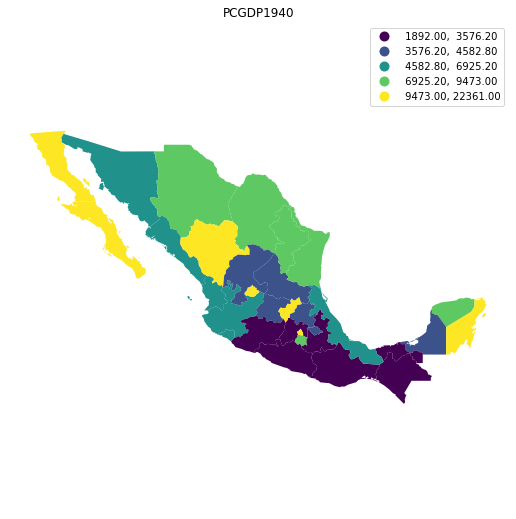

In [37]:
mx = geopandas.read_file('../data/mexico/mexicojoin.shp')
f, ax = plt.subplots(1, figsize=(9, 9))
mx.plot(ax=ax, column='PCGDP1940', legend=True, scheme='Quantiles')
ax.set_axis_off()
ax.set_title('PCGDP1940')
plt.axis('equal')
plt.show()

Note that the default for the legend is two report two decimal places. If we desire, this can be changed by overriding the `fmt` parameter:

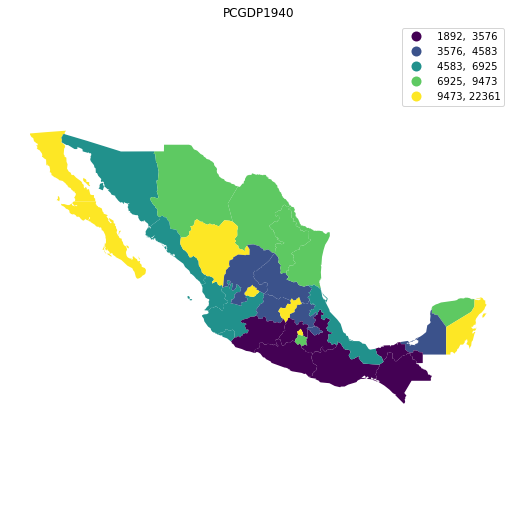

In [38]:
f, ax = plt.subplots(1, figsize=(9, 9))
mx.plot(ax=ax, column='PCGDP1940', legend=True, scheme='Quantiles', legend_kwds={'fmt':'{:.0f}'})
ax.set_axis_off()
ax.set_title('PCGDP1940')
plt.axis('equal')
plt.show()

The default color map used by `geopandas` is viridis, which is a multi-hue
sequential scheme, with the darker (lighter) hues representing lower (higher)
values for the attribute in question. The choice of a color scheme for a
choropleth map should be based on the type of variable under consideration
{cite}`Brewer1997mapping`. Generally, a distinction is drawn between three
types of numerical attributes:

- sequential
- diverging
- qualitative

### Sequential Color Schemes

Our attribute is measured in dollars and is characterized as a *sequential* attribute. To choose an appropriate sequential scheme we can override the `cmap` parameter:

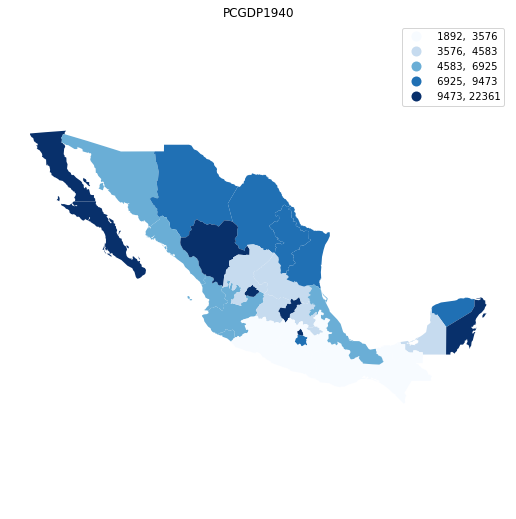

In [39]:
f, ax = plt.subplots(1, figsize=(9, 9))
mx.plot(ax=ax, column='PCGDP1940', legend=True, scheme='Quantiles', legend_kwds={'fmt':'{:.0f}'}, \
         cmap='Blues')
ax.set_axis_off()
ax.set_title('PCGDP1940')
plt.axis('equal')
plt.show()

which now uses a single-hue sequential color map with the lighter shades representing lower values. One difficulty with this map is that the poor states in the southern portion of Mexico blend into the background of the map display. This can be adjusted by overriding the `edgecolor`:


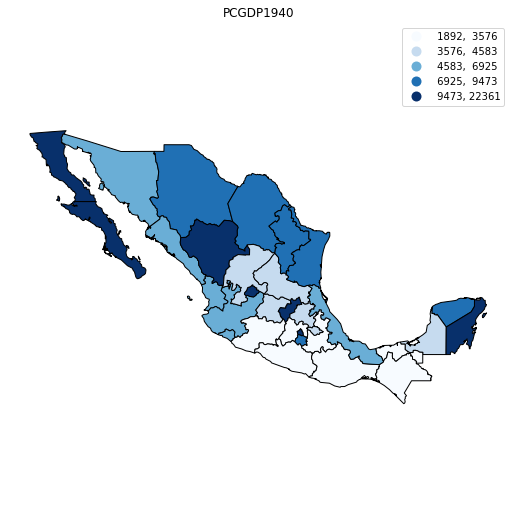

In [40]:
f, ax = plt.subplots(1, figsize=(9, 9))
mx.plot(ax=ax, column='PCGDP1940', legend=True, scheme='Quantiles', legend_kwds={'fmt':'{:.0f}'}, \
         cmap='Blues', edgecolor='k')
ax.set_axis_off()
ax.set_title('PCGDP1940')
plt.axis('equal')
plt.show()

for file in /proc/*/status ; do awk '/VmSwap|Name/{printf $2 " " $3}END{ print ""}' $file; done | sort -k 2 -n -r | less### Diverging Color Schemes

A slightly different type of attribute is the so-called "diverging" values attribute. This is
useful when one wishes to place equal emphasis on mid-range critical values as
well as extremes at both ends of the distribution. Light colors are used to
emphasize the mid-range class while dark colors with contrasting hues are used
to distinguish the low and high extremes.

To illustrate this for the Mexican
income data we can derive a new variable which measures the change in a state's
rank in the income distribution between 1940 to 2000:

In [41]:
rnk = mx.rank(ascending=False) # ascending ranks 1=high, n=lowest
rnk['NAME']=mx['NAME']
delta_rnk = rnk.PCGDP1940 - rnk.PCGDP2000
delta_rnk
cls = numpy.digitize(delta_rnk, [-5, 0, 5, 20])
cls

array([1, 1, 0, 2, 1, 2, 1, 1, 2, 3, 2, 2, 1, 1, 4, 3, 1, 1, 2, 2, 3, 1,
       2, 2, 2, 1, 0, 0, 2, 3, 2, 0])

Here we have created four classes for the rank changes: [-inf, -5), [-5, 0), [0,
5), [5, 20]. Note that these are descending ranks, so the wealthiest state in
any period has a rank of 1 and therefore when considering the change in ranks, a
negative change reflects moving down the income distribution.

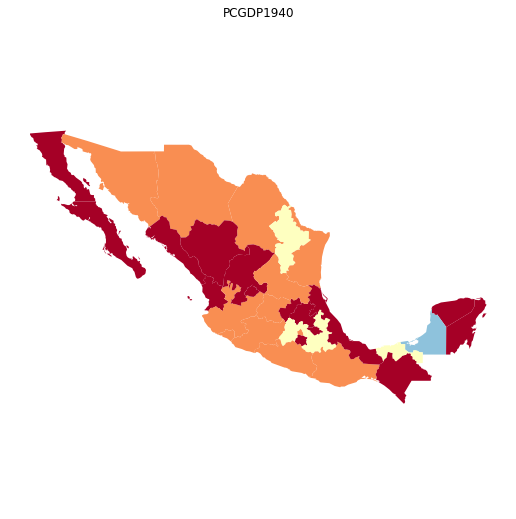

In [42]:
f, ax = plt.subplots(1, figsize=(9, 9))
mx.assign(cl=cls).plot(ax=ax, column='cl', categorical=True, cmap='RdYlBu',
           scheme='equal_interval', k=4)
ax.set_axis_off
ax.set_title('PCGDP1940')
plt.axis('equal')
plt.show()


Here the red (blue) hues are states that have moved downwards (upwards) in the
income distribution, with the darker hue representing a larger movement.

### Qualitative Color Schemes

The Mexico data set also has several variables that
are on a nominal measurement scale. One of these is a region definition variable
that groups individual states in contiguous clusters of similar characteristics:

In [43]:
mx['HANSON98'].head()

0    1.0
1    2.0
2    2.0
3    3.0
4    2.0
Name: HANSON98, dtype: float64

This regionalization scheme partitions Mexico into 5 regions. A naive (and
incorrect) way to display this would be to treat the region variable as
sequential and use a `UserDefined` classifier to display the regions:

In [44]:
import numpy as np
h5 = mapclassify.UserDefined(mx['HANSON98'], bins=np.arange(1,6).tolist())
h5.fmt = '{:.0f}'
h5

UserDefined     

Interval   Count
----------------
[1, 1] |     6
(1, 2] |     7
(2, 3] |    10
(3, 4] |     2
(4, 5] |     7

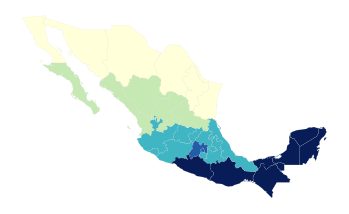

In [45]:
tmp = h5.plot(mx, axis_on=False)

This is not correct because the region variable is not on an interval scale, so
the differences between the values have no quantitative significance but rather
the values simply indicate region membership. However, the choropleth above gives
a clear visual cue that regions in the south have larger values
than those in the north, as the color map implies an intensity gradient.

A more appropriate visualization
is to use a "qualitative" color palette:

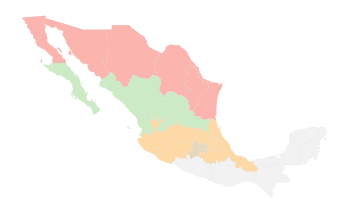

In [46]:
tmp = h5.plot(mx, cmap='Pastel1', axis_on=False)

## Conclusion

In this chapter we have considered the construction of choropleth maps for
spatial data visualization. The key issues of the choice of classification
scheme, variable measurement scale, spatial configuration and color palettes
were illustrated using PySAL's map classification module together with other
related packages in the PyData stack.

Choropleth maps are a central tool in the geographic data science arsenal as
they provide powerful visualizations of the spatial distribution of attribute
values. We have only touched on the basic concepts in this chapter, as there is
much more that can be said about cartographic theory and the design of effective
choropleth maps. Readers interested in pursuing this literature are encouraged
to see the references cited.

At the same time, given the philosophy underlying PySAL the methods we cover
here are sufficient for exploratory data analysis where the rapid and flexible
generation of views is critical to the work flow. Once the analysis is complete,
and the final presentation quality maps are to be generated, there are excellent
packages in the data stack that the user can turn to.

## Questions

1. A variable (such as population density measured for census tracts in a metropolitan area) can display a high degree of skewness. That is, the distribution may be very asymmetric, either with a few very values and a bulk of low ones; or a few very low values with a bulk of high values. What is an appropriate choice for a choropleth classification for a skewed variable?
2. Provide two solutions to the problem of ties when applying quantile classification to the following series: $y=[2,2,2,2,2,2,4,7,8,9,20,21]$ and $k=4$. Discuss the merits of each approach.
3. Which classifiers are appropriate for data that displays a high degree of multi-modality in its statistical distribution? 
4. Are there any colormaps that work well for multi-modal data?
5. Contrast and compare classed choropleth maps with class-less (i.e. continuous-scale) choropleth maps? What are the strengths and limitations of each type of visualization for spatial data?
6. In what ways do choropleth classifiers treat intra-class and inter-class heterogeneity differently? What are the implications of these choices?
7. To what extent do most commonly employed choropleth classification methods take the geographical distribution of the variable into consideration? Can you think of ways to incorporate the spatial features of a variable into a classification for a choropleth map?
8. Discuss the similarities between the choice of the number of classes in choropleth mapping, on the one hand, and the determination of the number of clusters in a data set on the other. What aspects of choropleth mapping differentiate the former from the latter?
9. The Fisher-Jenks classifier will always have more internally homogeneous classes than other k-classifiers. Given this, why might one decide on choosing a different k-classifier for a particular data set?
